Grupo 6  
Enrique Ramos García, Ignacio Regidor Prieto, Guillermo Mármol Burgos y Diego Forteza Benito.  


In [ ]:
#Importación de las librerías a utilizar durante la práctica
import os
from os.path import join
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import PIL

from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd


import seaborn as sns
from scipy import ndimage
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
from joblib import Parallel, delayed


#Practica Final


## Introduccion  
En esta práctica hemos establecido como objetivo crear una red neuronal que sea capaz, dando como input una imágen del cerebro, de distinguir si tienes Alzheimer y, si es que sí, de que grado. Para eso utilizaremos la base de datos de _kaggle_ [**Alzheimer's Dataset**](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images). Con este dataset y haciendo uso de la libreria de keras entrenaremos una red neuronal sequencial que combinara capas densas y filtros (capas convolucionales) para obtener finalmente una distribución de probabilidad (_softmax_). 


###Base de datos
El dataset de kaggle tiene un total de 6400 radiografías de cerebros etiquetadas en cuatro clases:

1. `MildDemented`: alzheimer leve
2. `VeryMildDemented`: alzheimer muy leve
3. `NonDemented`: sin alzheimer
4. `ModerateDemeneted`: alzheimer moderado

Además, las imágenes vienen ya divididas en dos subsets train y test.
Para importar el dataset de kaggle, habiendo importado el paquete os (`import os`) cambiamos el parametro _KAGGLE_CONFIG_DIR_ a la dirección `/content` (esto lo que hace es indicar donde queremos que se descargue el dataset diciendoselo a la terminal). Cabe mencionar que ponemos `/content` porque esta es la dirección por defecto de la terminal en colab. Posteriormente, utilizamos el método `!kaggle datasets download`, sirve para descargar datasets de kaggle. A este le añadimos los parámetros
1. `-d tourist55/alzheimers-dataset-4-class-of-images`: indicamos el directorio de la base de datos en kaggle
2. `--force`: forzamos su descarga cada vez que se ejecute esa línea. Esto es para evitar errores al ejecutar el código varias veces.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images --force

 94% 32.0M/34.1M [00:02<00:00, 23.1MB/s]
100% 34.1M/34.1M [00:02<00:00, 14.3MB/s]


Una vez descargada nos damos cuenta que el archivo se descarga en formato .zip (comprimido). Para descomprimirlo hacemos uso de una herramienta que sirve para manejar archivos. Esta es patool (`!pip install patool`). Importamos _patoolib_ y descomprimimos el dataset en `/content`

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/alzheimers-dataset-4-class-of-images.zip", outdir="/content")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
patool: Extracting /content/alzheimers-dataset-4-class-of-images.zip ...
patool: running /usr/bin/7z x -o/content -- /content/alzheimers-dataset-4-class-of-images.zip
patool: ... /content/alzheimers-dataset-4-class-of-images.zip extracted to `/content'.


'/content'

Una vez hecho esto ya tenemos los archivos del dataset a mano para empezar con su preparación

###Preprocesamiento de los datos
Tras importar los datos, continuamos con su transformación y preparación para luego entrenar la red neuronal. Para ello, primero definimos unas variables que utilizaremos más adelante:
1. **AUTOTUNE**: sirve para que a la hora de procesar los datos, se vayan preparando los siguientes. Se explica más adelante 
2. **BATCH_SIZE**: tamaño de los paquetes en que se dividiran las imágenes
3. **IMAGE_SIZE**: definimos el tamaño de las imágenes
4. **EPOCHS**: definimos el número de epocas que nuestra red neuronal hará para entrenarse

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [176, 208]
EPOCHS = 100

Ahora vamos a dividir los datos y guardarlos en diferentes variables. Para ello utilizamos el método `tf.keras.preprocessing.image_dataset_from_directory`. Este, como dice su nombre, nos permite extraer imágenes de un directorio. Los parámetros que definimos son 
- `/content/Alzheimer_s Dataset/...`: directorio del que se van a extraer las imágenes
- `image_size = IMAGE_SIZE`: tamaño de las imágenes
-`validation split = 0.2`: dividimos dejando un 20% de datos para validación
- `seed = 1234`: semilla que utilizamos para dividir aleatoriamente los datos
- `batch_size = BATCH_SIZE`: definimos el tamaño de los paquetes en los que vamos a dividir las imágenes
- `subset = 'training'`: el subset de las imágenes que cogemos es el de entrenamiento (en la segunda ponemos `'validation'` para coger los de validación)  

Finalmente, en `class_names` definimos el nombre de las clases y guardamos el número en num_class.

In [ ]:
train_data  = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train",
    seed=1234,
    image_size=IMAGE_SIZE,
    validation_split = 0.2,
    subset = 'training',
    batch_size=BATCH_SIZE,
)

val_data  = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train",
    seed=1234,
    image_size=IMAGE_SIZE,
    validation_split = 0.2,
    subset = 'validation',
    batch_size=BATCH_SIZE,
)
test_data  = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/test",
    seed=1234,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_data.class_names = class_names
test_data.class_names = class_names
val_data.class_names = class_names


num_class = len(class_names)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


Como podemos ver de los 5121 archivos del directorio `/train` el 20% son para validación (1024) y el resto para entrenamiento. Por otro lado, para test tenemos 1279. Por lo que, en total, tenemos 5121 + 1279 = 6400 imágenes.  
Ahora veamos como son. Para ello graficamos nueve imágenes del train_data. Con `.take(1)` lo que estamos diciendo es que de los paquetes (batch) en los que ha dividido las imágenes de entrenamiento coja uno. Luego, de este graficamos 9 images con sus respectivos labels

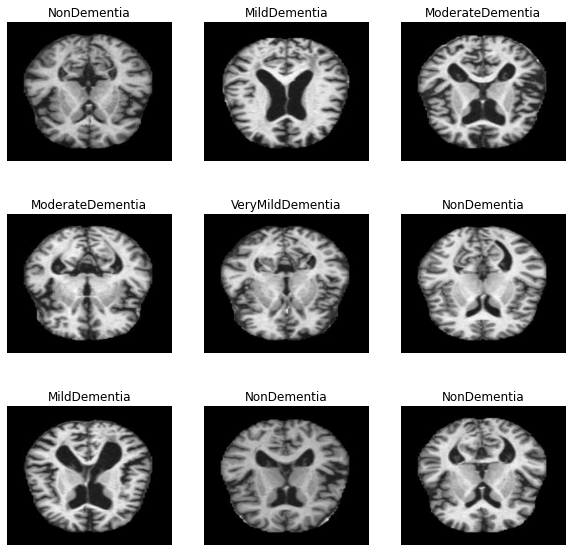

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

Ahora para pasar a los datos a _one_hot_encoding_ creamos una funcion que dada una imagen y su etiqueta, pase a categorical su etiqueta y luego devuelva ambas. Esto se lo aplicamos a todas las variables que contienen datos (train, val y test).

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, num_class)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

##Diseño del modelo
Para el diseño de nuestra red neuronal primero definiremos bloques de capas los cuales luego juntaremos creando el modelo final. Cabe destacar que nuestro modelo hace uso de además de convolucionales y densas unas que no hemos dado pero que nos topamos con ella investigando. Esta capa es **SeparableConv2d**. 

###Capa convolucional Separable
- Una capa _convolucional separable en profundidad_ trabaja de forma similar  una capa convolucional convencional. Se asemejan en que ambas trabajan aplicando un kernel a la matriz de input para así obtener un valor. No obstante, en lo que se diferencia este tipo de capa de las convolucionales casuales es que primero separa los canales (R,G,B) o profundidad de la matriz de entrada, disminuyendo así el número de parámetros y por tanto operaciones. Esto nos daría una matriz de x.x.profundidad a la que finalmente se le aplicaría un _pointwise convolution_ es decir kernels de x.x.profundidad. Por ejemplo, consideremos que tenemos una imagen RGB a la que le aplicamos una capa convolucional con ventanas de 3x3x3 con 64 filtros. El número de parámetros sería 3x3x3x64 + 64 = 1792 parámetros. Por otro lado con una capa separable serían (3x3x1x3(canales) + 3(sesgo)) + (1x1x3x64+64) = 286 parámetros. Véase las siguientes imágen y el ejemplo de la página [Machine Learning Mastery](https://machinelearningmastery.com/using-depthwise-separable-convolutions-in-tensorflow/).  

- Con esto, se consigue reducir el número de parámetros a pesar de realizar dos operaciones distintas en vez de una como en las capas convolucionales normales. De esta forma, se reduce el coste computacional y se reduce la probabilidad de sobreajuste a los datos de entrenamiento que puede producirse con un gran número de parámetros.

**CAPA CONVOLUCIONAL CONVENCIONAL**
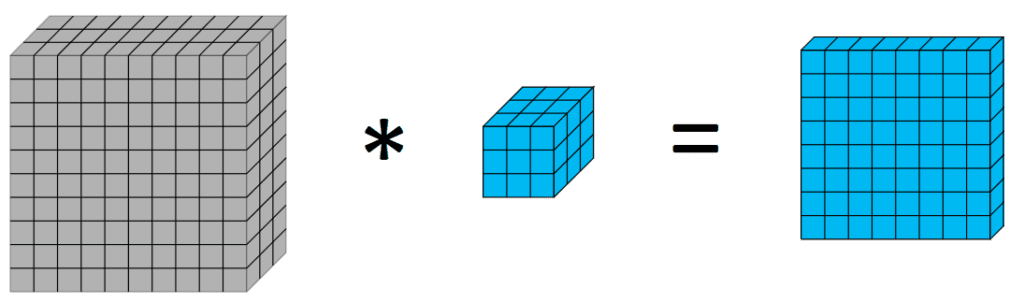

**CAPA CONVOLUCIONAL SEPARABLE EN PROFUNDIDAD**
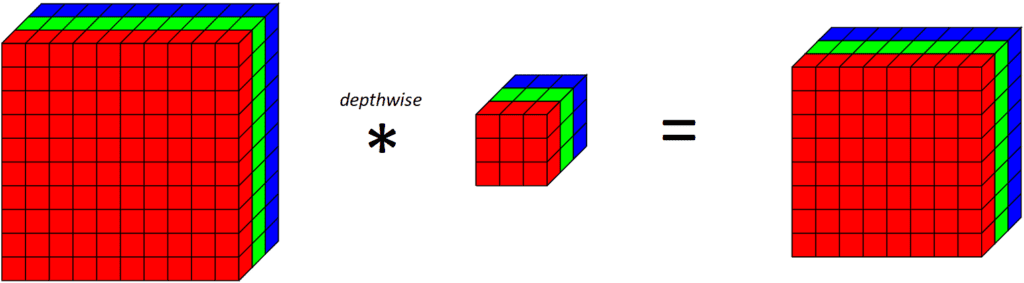
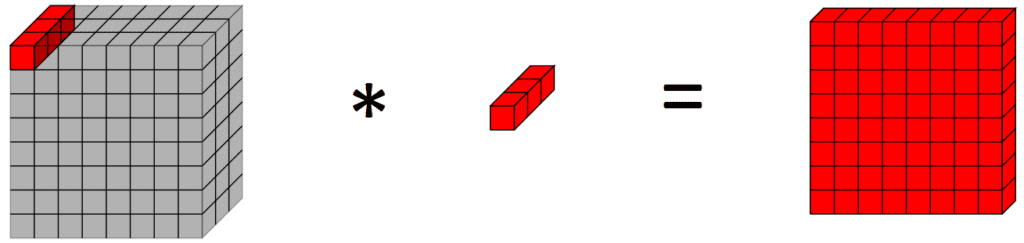

###Bloque Convolucional
Sabiendo lo que es una capa convolucional separable en profundidad, definamos nuestro bloque convolucional. Este bloque será uno secuencial (capas conectadas hacia delante) y constará de dos capas convolucionales separables en profundidad. Ambas con los filtros que se especifiquen al llamar al bloque y con kernels de 3x3. 

Los valores obtenidos se normalizan siempre después de salir de la capa convolucional separable utilizando batch normalization. Normalizar los valores permite que no difieran mucho en magnitud, lo que agiliza las operaciones y reduce el coste computacional optimizando así la red neuronal al hacerla más rápida y estable. Con la herramienta de batch normalization, nos aseguramos de que los datos siempre estén normalizados, ya que si solo se hiciese con los valores iniciales, la normalización se iría perdiendo al pasar por las distintas capas, pudiendo ser los valores bastante dispares en cuanto a magnitud. 

De esta forma, se consigue que se encuentren siempre normalizados antes de aplicar posteriormente una capa de max pooling. Esta última capa, condensa los datos quedándose con el mayor de cada subconjunto agrupado, evitando así un sobreajuste a los datos de entrenamiento y permitiendo que nuestra red sea ejecutable computacionalmente.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

###Bloque Denso
El bloque denso será tambien un bloque secuencial el cual constará de una capa densa con las neuronas indicadas al llamar al bloque, la normalización de los valores con BatchNormalization y posteriormente una capa `.Dropout`. Para recordar, esta lo que hacía es establecer valores a 0 aleatoriamente con un ratio de dropratio introducido al llamar al bloque.

Mediante el Dropout, conseguimos desactivar ciertas neuronas de una capa durante el entrenamiento, lo que permite que el resto se adapten mejor de forma individual al objetivo. Esto, se consigue ya que existe la posibilidad de que varias neuronas de una misma capa extraigan características idénticas o muy parecidas, lo que conlleva a un desperdicio de coste computacional. Además, de esta forma se evita una coadaptación de varias neuronas a características o patrones demasiados concretos o casuales de los datos de entrenamiento, al trabajar de forma poco independiente cada una de ellas. Así, al introducir ruido, se consigue una mejor generalización para datos que no pertenezcan al entrenamiento y un mejor aprovechamiento del coste computacional.

In [ ]:
def dense_block(neuronas, dropratio):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(neuronas, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropratio)
    ])
    
    return block

A continuación definimos dos bloques que usaremos al principio del modelo. Estos son:
1. `dimensionar_norm`: redimensiona las imágenes de entrada con una capa .Resizing y normaliza los valores con una capa .Rescaling (dividimos 1./255 para asegurarnos de que nos devuelve un float)
2. `generalizador`: este tiene una capa .RandomFlip, que da la vuelta tanto vertical como horizontalmente a las imágenes de forma aleatoria, y otra .RandomRotation, la cual rota aleatoriamente las imágenes. De esta forma, favorecemos el entrenamiento para reconocer patrones independientemente de su posición u orientación, lo cual para un caso como este es bastante útil. De esta forma, sacamos mayor provecho a las características de las redes convolucionales.

In [ ]:
image_sz = 140

dimensionar_norm = tf.keras.Sequential([
  layers.Resizing(image_sz, image_sz),
  layers.Rescaling(1./255)
])

generalizador = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
def def_modelo():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        dimensionar_norm,
        generalizador,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])
    
    return model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
print(exponential_decay_fn)

<function exponential_decay.<locals>.exponential_decay_fn at 0x7fe2dc430e50>


In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
modelo = def_modelo()
metricas = [tf.keras.metrics.AUC(name='auc'),Precision(name="precision"),Accuracy(name ='accuracy'),Recall(name="recall")]   
modelo.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=metricas)

Para este problema hemos decidido utilizar metricas distintas a las previamente utilizadas ya que hemos visto que en este caso son mejores a la hora de analizar los datos. En vez de Accuracy utilizamos AUC y Precision.

La razon principal por la que usamos AUC es porque la distribucion de nuestros datos no es uniforme. En nuestro caso (como se pudo ver a la hora de analizar los datos) la clase que menos individuos tiene es justamente la que queremos aprender a detectar mejor.

Accuracy es una forma de evaluar modelos que nos da el ratio o porcentaje de la cantidad de Positivos Verdaderos vs Numero total de entidades en el dataset. Accuracy es muy buen evaluador para datos uniformemente distribuidos pero con los que no Accuracy lleva a conclusiones erroneas. AUC sin embargo es el Area bajo la curva ROC. 

Una grafica ROC es una grafica que compara la tasa positivos verdaderos que hay con la tasa de falsos positivos.

La tasa de positivos verdaderos se calcula de la siguiente manera:

T.V.P= Verdaderos Positivos/(Verdaderos Positivos+Falsos Negativos)

La tasa de falsos positivos como:

T.F.P= Falsos Positivos/(Falsos Positivos+Verdaderos Negativos)

Usamos AUC para calcular el area bajo esta curva. Nuestra red ira ajustando y disminuyendo los falsos positivos hasta llegar un area de 1 (donde no hay falsos positivos y son todo positivos veraderos). Usar las areas hace mas sencillo comparar esta mejora.

A continuacion usamos Precision. Precision calcula la proporcion de positivos que han sido correctamente clasificados.

Precision= Verdaderos Positivos/(Verdaderos Positivos+Falsos Positivos)

Una precision de 1 implica que siempre clasifica bien los positivos.




In [ ]:
modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 140, 140, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 140, 140, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 140, 140, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 70, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 16)        2320      
                                                      

Las primeras dos capas secuenciales no hacen comparacion de parámetros porque primero los normailza y luego los rota pero no hace comparaciones.

La primera capa convolucional va recorriendo la imagen en ventanas de 3x3 creando así una capa oculta de 140x140 (142 pixeles - 3 de las ventanas + 1 de la primera iteración = 140). Posteriormente, pasa 16 filtros por esa nueva capa oculta y el sesgo por cada capa. El input shape de esta capa es (140,140,16) por los 16 filtros para cada ventana. Por otro lado, los parámetros que comparamos son 3x3 = 9 por los 16 filtros en 3 canales, más un sesgo por cada filtro da como resultado el siguiente cálculo: 3916+16=448

Como segundos valores para el maxpooling vemos que la cantidad de parámetros que compara para aprender es 0, ya que en pooling no se aprende, se simplifica la matriz a ventanas de 2x2. Vuelve a ocurrir lo mismo con el cuarto valor. En este caso las dimensiones son de (70,70,16). Al separar la matriz en ventanas de 2x2 divide las dimensiones de esta entre dos; luego sigue aplicando 32 filtros.

Aplicamos una segunda CC por lo que hay que volver a ver cuantos parámetros comparamos. Esta vez vemos que son, una vez más, ventanas de 3x3 = 9 que se multiplican por los 16 filtros anteriores. Esto lo multiplicamos con los filtros de la segunda capa que son 16, más un filtro por capa. Por tanto; (9 x 16) x 16 + 16 = 2320

A continuacion aplicamos un Depthwise Separable Convolution que es simplemente una convolucion en la que los pesos se aplican a un unico canal. El uso de este modelo convolucional es que la cantidad de numeros de parametros es mucho menor porque es un numero menor de operaciones. 


A continuacion aplicamos un Depthwise Separable Convolution donde comparamos 3x3 de la ventana * 16 canales; a esto le sumamos los datos de la capa convolucional que son 16 canales por 32 filtos mas 32 de los sesgos por filtro. Quedaria: (3x3x16)+(16x32+32)=688

En la segunda capa volvemos a repetir el prosceso 3x3 de la ventana x 32 canales; sumado a 32 canales por 32 filtros mas 32 sesgos. Quedaria (3x3x32)+(32x32+32)=1344

Seguimos aplicando capas Depthwise hasta finalmente obtener que se comparan un total de 746,804 parametros. 

A continuación, se entrena en modelo introduciendo los datos de entrenamiento, de validación y el número de épocas ya definido.
Además, se utiliza la herramienta callbacks, la cual nos permite ejecutar sentencias durante las distintas épocas del entrenamiento. Las callbacks utilizadas son:
- Checkpoint: para guardar los datos de los pesos durante las distintas épocas. Es empleado por el resto de callbacks.
- Early_stop: para parar el entrenamiento si este lleva bastantes épocas sin mejorar.
- Lr_scheduler: Reduce progresivamente el ratio de aprendizaje, lo que favorece caer en mínimos locales al principio del entrenamiento, pero converger a un resultado óptimo al final de este,
- ReduceLROnPlateau: si durante el entrenamiento empieza a dejar de mejorar la red neuronal, reduce el ratio de aprendizaje. 

In [ ]:
history = modelo.fit(
    train_data,
    validation_data=val_data,
    callbacks=[checkpoint, early_stop, lr_scheduler, ReduceLROnPlateau(patience=5, factor=.5)],
    epochs=EPOCHS
)

Epoch 1/100
129/129 [==============================] - 21s 88ms/step - loss: 1.1358 - auc: 0.7697 - precision: 0.5474 - accuracy: 0.0000e+00 - recall: 0.3058 - val_loss: 6.1007 - val_auc: 0.6782 - val_precision: 0.4961 - val_accuracy: 0.0000e+00 - val_recall: 0.4941 - lr: 0.0100
Epoch 2/100
129/129 [==============================] - 11s 83ms/step - loss: 0.9753 - auc: 0.8095 - precision: 0.6382 - accuracy: 0.0000e+00 - recall: 0.2841 - val_loss: 1.3615 - val_auc: 0.6467 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0089
Epoch 3/100
129/129 [==============================] - 11s 84ms/step - loss: 0.9674 - auc: 0.8120 - precision: 0.6694 - accuracy: 0.0000e+00 - recall: 0.2773 - val_loss: 1.2222 - val_auc: 0.8098 - val_precision: 0.5645 - val_accuracy: 0.0000e+00 - val_recall: 0.3975 - lr: 0.0079
Epoch 4/100
129/129 [==============================] - 12s 90ms/step - loss: 0.9566 - auc: 0.8142 - precision: 0.6985 - accuracy: 0.0000e+00 - recall: 0

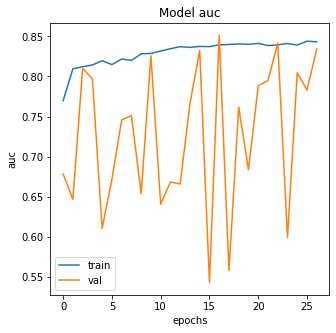

In [ ]:
fig1, plot1 = plt.subplots(1,1, figsize=(5,5))
plot1.plot(history.history['auc'])
plot1.plot(history.history['val_auc'])
plot1.set_title('Model auc')
plot1.set_xlabel('epochs')
plot1.set_ylabel('auc')
plot1.legend(['train', 'val'])

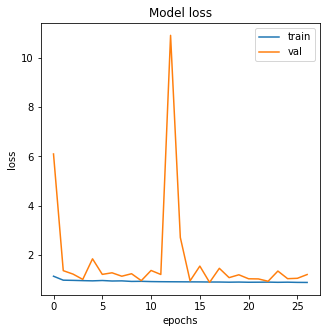

In [ ]:
fig2, plot2 = plt.subplots(1,1, figsize=(5,5))
plot2.plot(history.history['loss'])
plot2.plot(history.history['val_loss'])
plot2.set_title('Model loss')
plot2.set_xlabel('epochs')
plot2.set_ylabel('loss')
plot2.legend(['train', 'val'])

Con las gráficas podemos observar con los datos de entrenamiento que el modelo se ajusta enseguida a la red neuronal obteniendo en las primeras épocas una gran precisión y un valor bajo de loss score, reduciéndose enseguida la magnitud del gradiente en las 2 gráficas. De esto, se puede deducir que podría ser demasiado elevado el número de épocas del modelo.

Por otro lado, los datos de validación son bastante oscilantes, y no se obtienen valores mucho más bajos que los obtenidos en las primeras épocas, por lo que llegaríamos a la misma conclusión. Para obtener un buen resultado, se debería parar el entrenamiento en un número menor de épocas, o en algún valor alto de precisión y bajo de loss score de alguna de las oscilaciones. Además, estas oscilaciones reducen notablemente la eficacia de los callbacks de Early_stop y ReduceLROnPlateau utilizadas, ya que no llegan a detectar que se estabilice el modelo.

Estas deducciones, se ven confirmadas con los valores obtenidos al evaluar el modelo con datos no utilizados en el entrenamiento, donde con otro número de épocas se podría haber tenido seguramente una mayor precisión.
En conclusión, el modelo tiene margen de mejora a pesar del gran número de herramientas empleadas, lo cual se podría conseguir probando distintos valores de hiperparámetros.

# Mejoras a Futuro


Este modelo se ha entrenado con una base de datos que contiene relativamente pocas imágenes, concretamente 6000. Para mejorar la detección de Alzheimer de la red neuronal, se puede aumentar el tamaño de los datos de entrenamiento para una mejor generalización y flexibilidad. Esta, es una de las ventajas del Machine Learning, donde los modelos creados continúan mejorando a medida que ampliamos los datos de los que se dispone, en contraste con la programación clásica y sus algoritmos.

Además, en este modelo ya que se utilizan las redes convolucionales, también se podría aplicar una mayor o menor cantidad de filtros para observar como mejora la red y donde se crea un sobreajuste a los datos de entrenamiento al extraer características demasiado específicas de estos. 

Finalmente, se puede probar a realizar cambios estructurales en el modelo en cuanto al número de capas, tipos y número de neuronas en ellas; y así estudiar como afectan estos cambios a la precisión para realizar predicciones.